Imports, run first!

In [1]:
#Data manipulation:

import numpy as np
import pandas as pd

#Plotting:

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

#Machine learning:

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from generate_dataset import dat_to_df

#Misc:

from tqdm import tqdm


Create all four dataframes from .dat files


In [2]:
df_SW = dat_to_df("small_wave/tec.dat","small_wave/mesh.dat")
df_LW = dat_to_df("large_wave/tec.dat","large_wave/mesh.dat")
df_OH = dat_to_df("one_hill/tec.dat","one_hill/mesh.dat")
df_TH = dat_to_df("two_hills/tec.dat","two_hills/mesh.dat")

Method for scaling every column in a dataframe, returns a copy of the dataframe with all variables scaled.

In [3]:
def scale_all(df:pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler() 
    df_temp = df.copy(deep=True)
    for col in df.columns:
        df_temp[col] = scaler.fit_transform(df[[col]])

    return df_temp    

Apply scaling to the dataframe, in this we create a scaled dataframe as a copy.

In [4]:
df_SW_scaled = scale_all(df_SW)
df_LW_scaled = scale_all(df_LW)
df_OH_scaled = scale_all(df_OH)
df_TH_scaled = scale_all(df_TH)

Correlation matrix for the different variables:

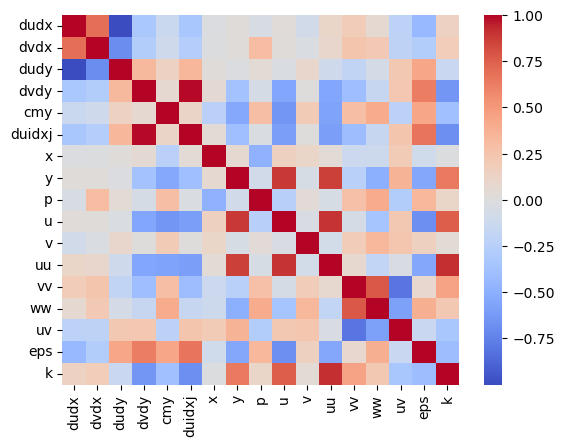

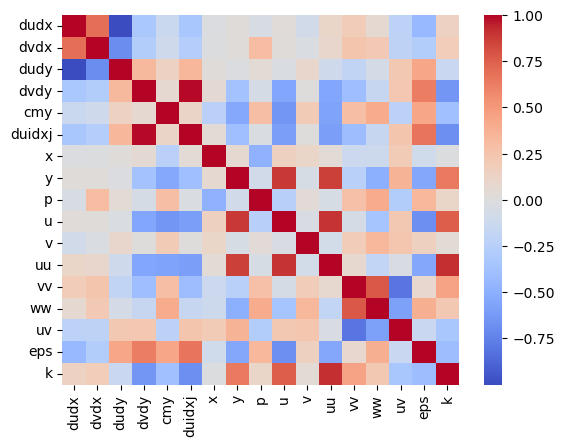

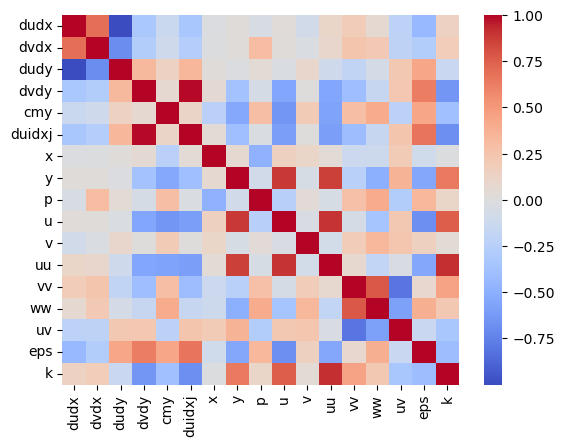

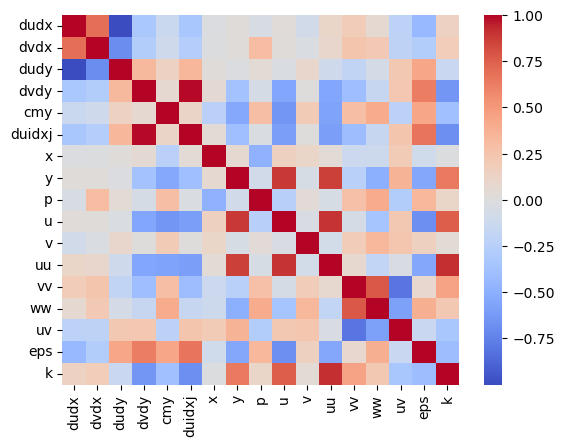

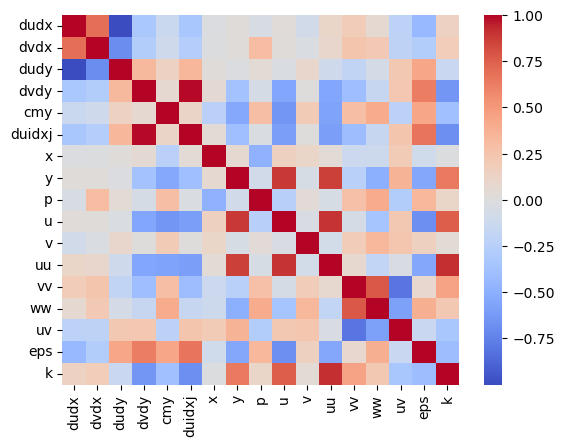

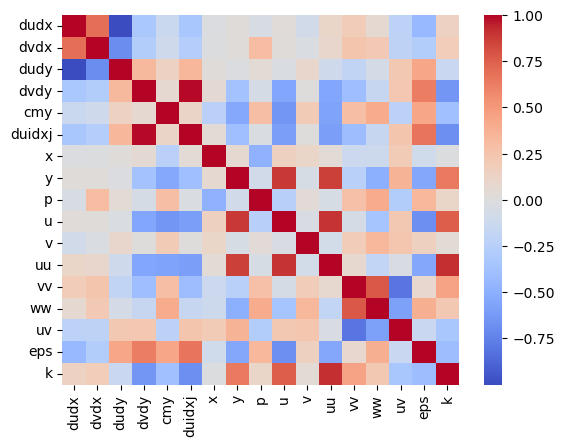

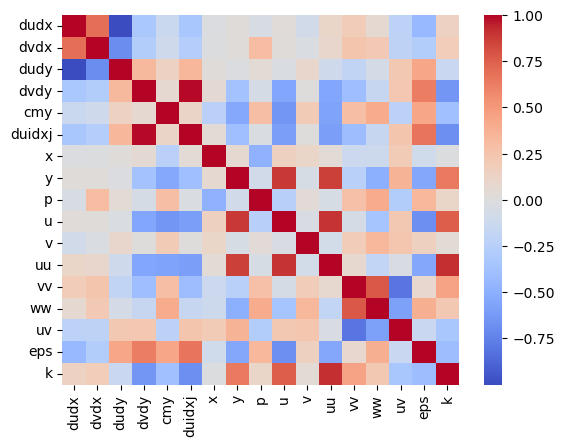

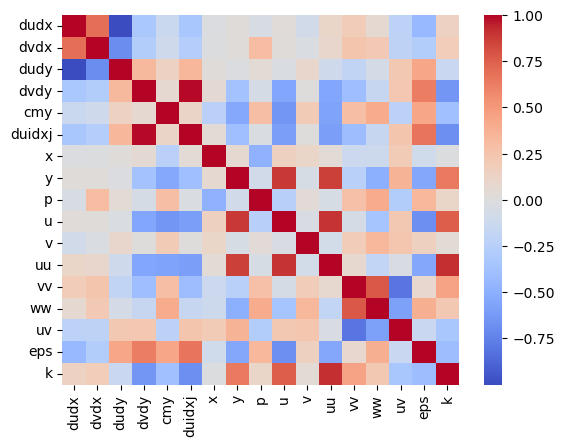

In [8]:
for df in [df_SW,df_LW,df_OH,df_TH,df_SW_scaled,df_LW_scaled,df_OH_scaled,df_TH_scaled]:
    plt.figure()
    sns.heatmap(df_SW.corr(), cmap='coolwarm')
    plt.show()

Set up the machine learning model, in this case we test it on df_SW:


In [5]:
#Set up input/output variable(s)
X=df_SW_scaled[['dudx','dudy']]
Y=df_SW['cmy'].values

#Split into trainig set and test set:
X_train_SW, X_test_SW, Y_train_SW, Y_test_SW = train_test_split(X, Y, test_size=0.2, random_state=42)

#Choose model and fit it:
model = SVR(kernel='rbf', C=6, epsilon=0.01)
svr_SW = model.fit(X_train_SW, Y_train_SW)

In [6]:
def scatter_3d(df,x,y,z,title):
    fig = px.scatter_3d(df, 
                    x=x, 
                    y=y, 
                    z=z, 
                    opacity=0.8, color_discrete_sequence=[z],
                    height=1000, width=1000
                   )

    # Set figure title
    fig.update_layout(title_text=title,
                    scene_camera_eye=dict(x=1.5, y=1.5, z=0.25), 
                    scene_camera_center=dict(x=0, y=0, z=-0.2),
                    scene = dict(xaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='lightgrey'),
                                yaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='lightgrey'
                                            ),
                                zaxis=dict(backgroundcolor='white',
                                            color='black', 
                                            gridcolor='lightgrey')))

    # Update marker size
    fig.update_traces(marker=dict(size=2))

    fig.show()

In [13]:
scatter_3d(df_SW,df_SW['x'],df_SW['y'],df_SW['duidxj'],"title")

In [8]:

# ----------- For creating a prediciton plane to be used in the visualization -----------
# Set Increments between points in a meshgrid
mesh_size = 0.5

# Identify min and max values for input variables
x_min, x_max = X['dudx'].min(), X['dudx'].max()
y_min, y_max = X['dudy'].min(), X['dudy'].max()

# Return evenly spaced values based on a range between min and max
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)

# Create a meshgrid
xx, yy = np.meshgrid(xrange, yrange)

pred_LR = svr_SW.predict(np.c_[xx.ravel(), yy.ravel()])
pred_LR = pred_LR.reshape(xx.shape)

# Note, .ravel() flattens the array to a 1D array,
# then np.c_ takes elements from flattened xx and yy arrays and puts them together,
# this creates the right shape required for model input

# prediction array that is created by the model output is a 1D array,
# Hence, we need to reshape it to be the same shape as xx or yy to be able to display it on a graph

# Create a 3D scatter plot with predictions
fig = px.scatter_3d(df_SW, x=df_SW_scaled['dudx'], y=df_SW_scaled['dudy'], z=df_SW['cmy'], 
                    opacity=0.8, color_discrete_sequence=['black'],
                    width=1000, height=900
                   )

# Set figure title and colors
fig.update_layout(title_text="Scatter 3D Plot with Linear Regression Prediction Surface",
                  scene_camera_eye=dict(x=1.5, y=1.5, z=0.25), 
                  scene_camera_center=dict(x=0, y=0, z=-0.2),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='lightgrey'),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='lightgrey'
                                          ),
                               zaxis=dict(backgroundcolor='white',
                                          color='black', 
                                          gridcolor='lightgrey')))
# Update marker size
fig.update_traces(marker=dict(size=2))

# Add prediction plane
fig.add_traces(go.Surface(x=xrange, y=yrange, z=pred_LR, name='LR', 
                          colorscale=px.colors.sequential.Sunsetdark, showscale=False))

fig.show()

c:\Users\Ole\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but SVR was fitted with feature names



Testing different values for C

100%|██████████| 30/30 [27:37<00:00, 55.25s/it]


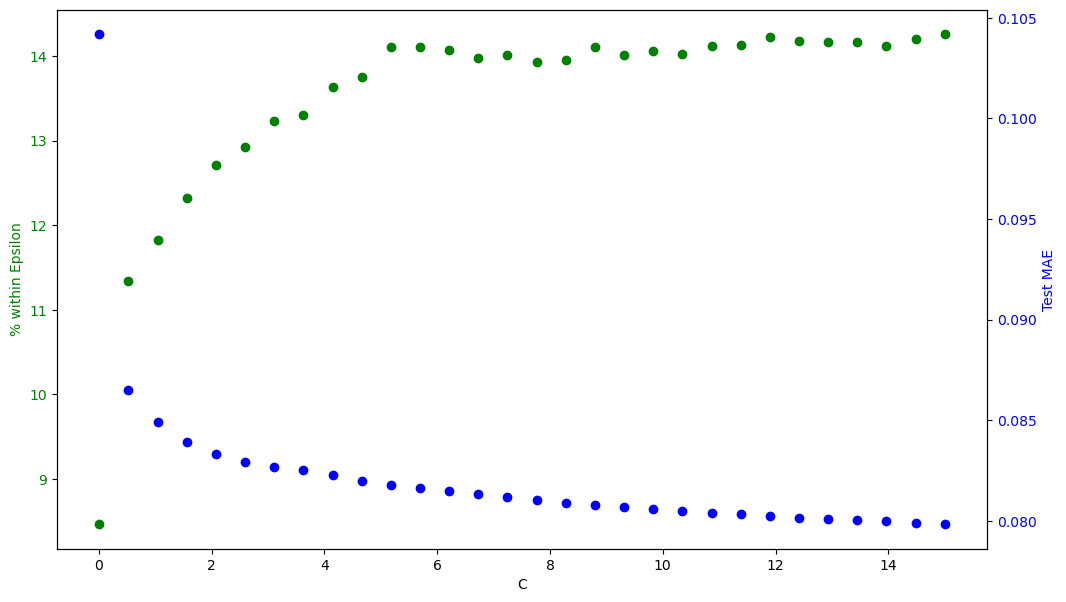

In [16]:
mae = []    
eps_perc = []

c_range = np.linspace(0.01, 15, num=30)
eps = 0.01

for c in tqdm(c_range):
    
    varied_svr = SVR(kernel = 'rbf', C=c, epsilon = eps)
    varied_svr.fit(X_train_SW, Y_train_SW)
    
    test_mae = mean_absolute_error(Y_test_SW, varied_svr.predict(X_test_SW))
    mae.append(test_mae)
    
    perc_within_eps = 100*np.sum(abs(Y_test_SW-varied_svr.predict(X_test_SW)) <= eps) / len(Y_test_SW)
    eps_perc.append(perc_within_eps)

fig, ax1 = plt.subplots(figsize=(12,7))

color='green'
ax1.set_xlabel('C')
ax1.set_ylabel('% within Epsilon', color=color)
ax1.scatter(c_range, eps_perc, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color='blue'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Test MAE', color=color)  # we already handled the x-label with ax1
ax2.scatter(c_range, mae, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.show()

Scale the neccecary columns of all dataframes, the scaled columns are added to the original   
dataframe giving a new column 'var_scaled' in addition to the original column 'var' 

In [ ]:

def scale_df(df:pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler() 

    df['duidxj_scaled'] = scaler.fit_transform(df[['duidxj']])
    df['k_scaled']      = scaler.fit_transform(df[['k']])
    df['uv_scaled']     = scaler.fit_transform(df[['uv']])
    df['eps_scaled']    = scaler.fit_transform(df[['eps']])
    df['p_scaled']      = scaler.fit_transform(df[['p']])
    df['vv_scaled']     = scaler.fit_transform(df[['vv']])
    df['uu_scaled']     = scaler.fit_transform(df[['uu']])
    
    return df